In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# resnet50v2_transfer_learning

In [3]:
# pip install pycm

In [4]:
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,roc_curve, precision_score,recall_score,f1_score,cohen_kappa_score,confusion_matrix,mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense
from pycm import ConfusionMatrix
from collections import Counter
from os import listdir
from math import sqrt

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import itertools
import os, shutil
import cv2

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,2,3,4"
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.99)
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

print("tf version:", tf.__version__)

tf version: 2.12.0


In [6]:
def load_data(dir_list, image_size):
    X = []
    y = []
    all_image_with_label = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+ "/"+ filename)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            image_label_set_label = (0, 1)[directory[-4:] == 'fire']
            image_name_with_label = filename, image_label_set_label
            all_image_with_label.append(image_name_with_label)
            np.savetxt("/results/resnet50v2_image_data_feature_save.csv", all_image_with_label, delimiter=",", fmt='%s')
            image_name_matrix_with_label = image, filename, image_label_set_label
            X.append(image_name_matrix_with_label)
            y.append((0, 1)[directory[-4:] == 'fire'])

    X = np.array(X)
    y = np.array(y)
    
    print(Counter(y))
    
    return X, y

def image_split_folder(source, destination_fire, destination_no_blaze, all_data):
    shutil.rmtree(destination_fire, ignore_errors=True)
    shutil.rmtree(destination_no_blaze, ignore_errors=True)
    os.makedirs(destination_fire)
    os.makedirs(destination_no_blaze)
    for directory_split_folder_name in source:
        files_create = os.listdir(directory_split_folder_name)
        for target, label in all_data:
            for f_crt in files_create:
                if target == f_crt:
                    if label == 1:
                        shutil.copy(directory_split_folder_name + f_crt, destination_fire + f_crt)
                    elif label == 0:
                        shutil.copy(directory_split_folder_name + f_crt, destination_no_blaze + f_crt)

def pred_fire_image_split_carry(X_test_name, pred_class, predictions):
    pred_target_with_label_01 = np.vstack((X_test_name[:,1], pred_class)).T
    pred_target_with_label_possibility = np.vstack((X_test_name[:,1], predictions)).T
    image_split_folder(["/kaggle/input/dataset/wildfires/fire/", "/kaggle/input/dataset/wildfires/no_blaze/"], "/results/pred/fire/", "/results/pred/no_blaze/", pred_target_with_label_01)
    np.savetxt("/results/pred/resnet50v2_imagenet_fire_or_no_01.csv", pred_target_with_label_01, delimiter=",", fmt='%s')
    np.savetxt("/results/pred/resnet50v2_imagenet_fire_or_no_possibility.csv", pred_target_with_label_possibility, delimiter=",", fmt='%s')

def image_to_4d(datas):
    list_to_4d_all_data = []
    for data_list_find in datas[:,0]:
        list_to_4d_all_data.append(data_list_find)
    list_to_4d_all_data = np.array(list_to_4d_all_data)
    
    return list_to_4d_all_data

def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy'] 
    
    np.savetxt('/results/resnet50v2_imagenet_training_loss.csv', train_loss, fmt="%1.16f", delimiter=",")
    np.savetxt('/results/resnet50v2_imagenet_validation_loss.csv', val_loss, fmt="%1.16f", delimiter=",") 

    np.savetxt('/results/resnet50v2_imagenet_training_accuracy.csv', train_acc, fmt="%1.16f", delimiter=",")
    np.savetxt('/results/resnet50v2_imagenet_val_accuracy.csv', val_acc, fmt="%1.16f", delimiter=",") 
        
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc="best")
    plt.savefig('/results/resnet50v2_imagenet_loss.jpg', dpi=600, bbox_inches='tight')
    plt.show()
    
    print("\n") 

    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc="best")
    plt.savefig('/results/resnet50v2_imagenet_accuracy.jpg', dpi=600, bbox_inches='tight')
    plt.show()

def build_model(img_shape):
    
    model = Sequential()
    
    model.add(ResNet50V2(input_shape = (img_shape), include_top = False, weights="imagenet", pooling="max"))

    model.add(Dense(2, activation="softmax"))
    
    return model
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label',labelpad = 5)
    plt.xlabel('Predicted label', labelpad = 15)
    plt.savefig("/results/resnet50v2_imagenet_plt_cm.jpg", dpi=300, bbox_inches='tight')
    plt.show()

def statistc_analysis(actual,predict_classes_find):
    
    np.savetxt('/results/resnet50v2_imagenet_pred.csv', predict_classes_find, fmt="%d", delimiter=",")
    np.savetxt('/results/resnet50v2_imagenet_actual_test.csv', actual, fmt="%d", delimiter=",")    
    
    accuracy = accuracy_score(actual, predict_classes_find)
    print('Accuracy: %0.4f' % accuracy)
    
    precision = precision_score(actual, predict_classes_find)
    print('Precision: %0.4f' % precision)
    
    recall = recall_score(actual, predict_classes_find)
    print('Recall: %0.4f' % recall)
    
    f1 = f1_score(actual, predict_classes_find)
    print('F1 score: %0.4f' % f1)
    
    kappa = cohen_kappa_score(actual, predict_classes_find)
    print('Cohens kappa: %0.4f' % kappa)
    
    roc_auc_threshold = roc_auc_score(actual, predict_classes_find)
    print('ROC AUC: %0.4f' % roc_auc_threshold)
    print("\n")
    
    plt.figure()
    cnf_matrix = confusion_matrix(actual, predict_classes_find, labels=[0,1])
    plot_confusion_matrix(cnf_matrix, classes=['No Fire', 'Fire'], normalize= False,  title='Confusion matrix')
    print("\n")
        
    print("\n")
    print ('Report : ')
    target_names = ['No Fire', 'Fire']
    print (classification_report(actual, predict_classes_find,target_names=target_names, digits=2))
    print("\n")
    
    mse = mean_squared_error(actual, predict_classes_find)
    print('MSE: %0.4f' % mse)
    
    rmse = sqrt(mse)
    print('RMSE: %0.4f' % rmse)
    print("\n")    
           
    fpr, tpr, thresholds = roc_curve(actual, predict_classes_find)
    roc_auc_threshold = 'ResNet50V2 = %.4f' % (roc_auc_threshold)
    plt.plot(fpr, tpr,  color='#2626ff', label=roc_auc_threshold)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='', linewidth=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="lower right")
    plt.xlabel('1-Specificity (False Positive Rate)')
    plt.ylabel('Sensitivity (True Positive Rate)')
    plt.savefig("/results/resnet50v2_imagenet_roc_curve.jpg", dpi=300, bbox_inches='tight')
    plt.show()    
    print("\n") 
    
def overall_statistics(actual, predict_classes_find):
    
    cm = ConfusionMatrix(actual_vector=actual,predict_vector=predict_classes_find)
    
    print(cm)

def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error:' +  directory)

In [7]:
create_folder('/results/')

In [9]:
X, y = load_data(["/kaggle/input/dataset/wildfires/no_blaze", "/kaggle/input/dataset/wildfires/fire"], (224,224))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

Counter({0: 732, 1: 720})


/tmp/ipykernel_33/3061990163.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)


In [10]:
X_train_list_to_4d = image_to_4d(X_train)
X_test_list_to_4d = image_to_4d(X_test)

actual=y_test

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

img_shape = (224, 224, 3)
model = build_model(img_shape)
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 1.4493 - accuracy: 0.8596 
Epoch 1: val_loss improved from inf to 50.90025, saving model to /results/resnet50v2_imagenet.hdf5
19/19 [==============================] - 457s 23s/step - loss: 1.4493 - accuracy: 0.8596 - val_loss: 50.9002 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.9302 
Epoch 2: val_loss improved from 50.90025 to 22.10873, saving model to /results/resnet50v2_imagenet.hdf5
19/19 [==============================] - 443s 23s/step - loss: 0.6109 - accuracy: 0.9302 - val_loss: 22.1087 - val_accuracy: 0.4809 - lr: 0.0010
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.1816 - accuracy: 0.9404 
Epoch 3: val_loss did not improve from 22.10873
19/19 [==============================] - 420s 22s/step - loss: 0.1816 - accuracy: 0.9404 - val_loss: 95.7766 - val_accuracy: 0.4809 - lr: 0.0010
Epoch 4/50
19/19 [===========

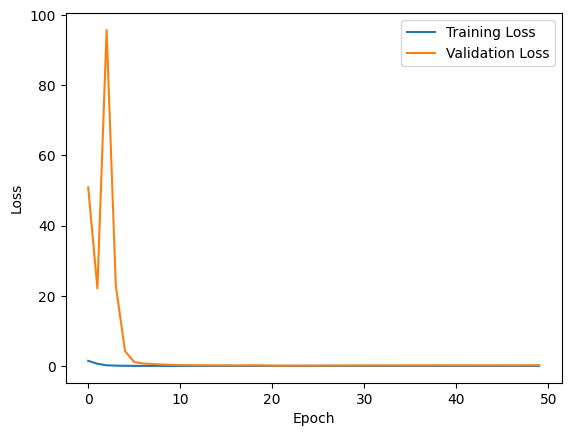

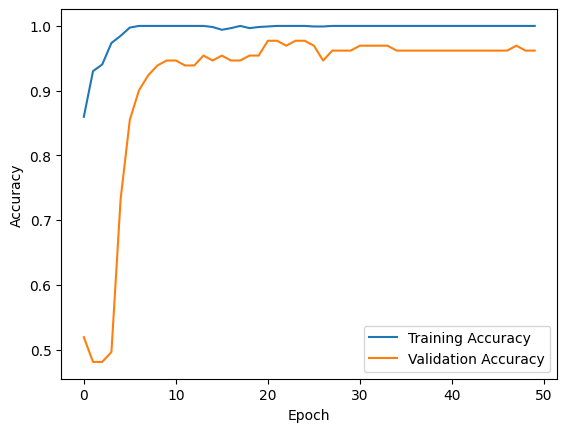

In [11]:
filepath="/results/resnet50v2_imagenet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=0)
history = model.fit(X_train_list_to_4d, y_train, batch_size=64, epochs=50, validation_split=0.10, verbose=1, callbacks=[checkpoint, reduce_lr])
history=history.history
 
plot_metrics(history)

In [12]:
model = load_model('/results/resnet50v2_imagenet.hdf5')

test_loss, test_acc = model.evaluate(X_test_list_to_4d, y_test, verbose=0)
print(f"Test loss : {test_loss:0.4}, Test Accuracy: {test_acc:0.4}")

print("\n")

Test loss : 0.1297, Test Accuracy: 0.9658




In [13]:
predictions = model.predict(X_test_list_to_4d, verbose=0)
predict_classes_find=[]
predictions_end=[]
for prd_clssv in predictions:
    predictions_end.append(max(prd_clssv))
    predict_classes_find.append(prd_clssv.argmax())  
predict_classes_find=np.array(predict_classes_find)
predictions_end=np.array(predictions_end)

Accuracy: 0.9658
Precision: 0.9474
Recall: 0.9863
F1 score: 0.9664
Cohens kappa: 0.9315
ROC AUC: 0.9658




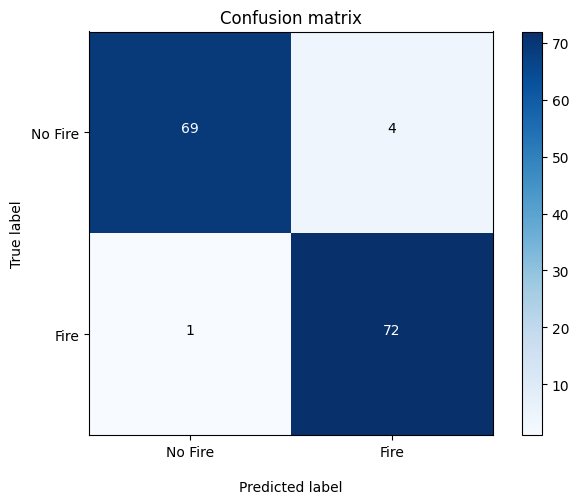





Report : 
              precision    recall  f1-score   support

     No Fire       0.99      0.95      0.97        73
        Fire       0.95      0.99      0.97        73

    accuracy                           0.97       146
   macro avg       0.97      0.97      0.97       146
weighted avg       0.97      0.97      0.97       146



MSE: 0.0342
RMSE: 0.1851




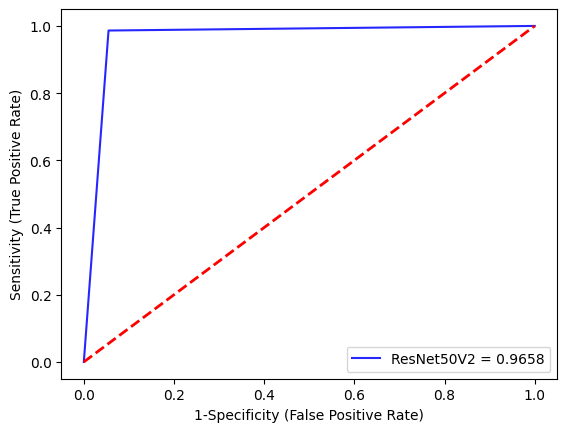

In [14]:
statistc_analysis(actual, predict_classes_find)

In [15]:
pred_fire_image_split_carry(X_test, predict_classes_find, predictions_end)

In [16]:
print("*"*30,"overall statistics start","*"*30)
overall_statistics(actual, predict_classes_find)
print("*"*30,"overall statistics end","*"*30)

****************************** overall statistics start ******************************
Predict  0        1        
Actual
0        69       4        

1        1        72       





Overall Statistics : 

95% CI                                                            (0.93625,0.99525)
ACC Macro                                                         0.96575
ARI                                                               0.86679
AUNP                                                              0.96575
AUNU                                                              0.96575
Bangdiwala B                                                      0.9331
Bennett S                                                         0.93151
CBA                                                               0.94629
CSI                                                               0.93229
Chi-Squared                                                       126.89925
Chi-Squared DF                            